In [54]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import least_squares

t = np.linspace(0, 0.004*20000, 20001)
delta_t = 0.004
n_values = np.arange(11)
gauss_params = [5000, 0.25, 8e+00, 100, 0.2, 9, 50, 0.65, 10, 1.5e+00]
model_params = [0.009, 6, 1/3]

def skewed_IRF_with_small_peak(t, A1, sigma1, mu1, A2, sigma2, mu2, A3, sigma3, mu3, b):
    # Main Gaussian peak
    main_peak = A1 / (sigma1 * np.sqrt(2 * np.pi)) * np.exp(-((t - mu1)**2) / (2 * sigma1**2))
    
    # Smaller Gaussian peak to the right-hand side
    small_peak = A2 / (sigma2 * np.sqrt(2 * np.pi)) * np.exp(-((t - mu2)**2) / (2 * sigma2**2))

    smaller_peak =  A3 / (sigma3 * np.sqrt(2 * np.pi)) * np.exp(-((t - mu3)**2) / (2 * sigma3**2))
    
    # Combine the main peak, the small peak, and the baseline offset
    irf = main_peak + small_peak +smaller_peak + b

    return irf

def skewed_IRF_with_small_peak_noise (t, A1, sigma1, mu1, A2, sigma2, mu2, A3, sigma3, mu3, b):
    # Main Gaussian peak
    main_peak = A1 / (sigma1 * np.sqrt(2 * np.pi)) * np.exp(-((t - mu1)**2) / (2 * sigma1**2))
    
    # Smaller Gaussian peak to the right-hand side
    small_peak = A2 / (sigma2 * np.sqrt(2 * np.pi)) * np.exp(-((t - mu2)**2) / (2 * sigma2**2))

    smaller_peak =  A3 / (sigma3 * np.sqrt(2 * np.pi)) * np.exp(-((t - mu3)**2) / (2 * sigma3**2))
    
    # Combine the main peak, the small peak, and the baseline offset
    irf = main_peak + small_peak +smaller_peak + b
    noise_level = 0.0008 * max(irf)
    noise = np.random.normal(loc=0, scale=noise_level, size=irf.shape)
    return np.clip(irf + noise, a_min=0, a_max=None)

IRF_noisy = skewed_IRF_with_small_peak_noise(t, *gauss_params)
IRF_no_noise = skewed_IRF_with_small_peak(t, *gauss_params)

def single_exp_model(t, a, tau, B):
    model = a * (np.exp(-(t / tau)**B) * np.exp(-t / tau))
    # Perform convolution of the model with the input response function (irf)
    raw_convolution = scipy.signal.fftconvolve(model, IRF_no_noise, mode='full')[:len(t)]
    # Calculate noise level as a percentage of the maximum point of the raw convolution
    noise_level = 0.0008 * max(raw_convolution)
    # Generate random noise
    noise = np.random.normal(loc=0, scale=noise_level, size=raw_convolution.shape)
    # Add noise to the raw convolution
    noisy_convolution = raw_convolution + noise
    return noisy_convolution


def double_exp_model_approx(t, C, a1, tau1, tau2, c ):   
    if a1 >= 1:
        a1 /= (a1 + 0.1)   
    a2 = 1 - a1
    model = C*(a1 * np.exp(-t / tau1) + a2 * np.exp(-t / tau2)) + c
    raw_convolution = scipy.signal.fftconvolve(model, IRF_noisy, mode='full')[:len(t)]
    return raw_convolution
    
def single_exponential_approx(t, A, tau, c):
    single_exp_decay_1 = A * np.exp(- (t / tau)) - c 
    raw_convolution = scipy.signal.fftconvolve(single_exp_decay_1, IRF_noisy, mode='full')[:len(t)]
    return raw_convolution

def triple_exp_model_approx(t, C, a1, a2, tau1, tau2, tau3, c):
    # Ensure sum of coefficients equals 1 and all are positive
    total_a = a1 + a2
    if total_a > 1:
        a1 /= total_a
        a2 /= total_a
        a3 = 0
    else:
        a3 = 1 - total_a
    
    # Ensure all coefficients are positive
    a1 = max(a1, 0)
    a2 = max(a2, 0)
    a3 = max(a3, 0)
    
    model = C * (a1 * np.exp(-t / tau1) + a2 * np.exp(-t / tau2) + a3 * np.exp(-t / tau3)) - c
    raw_convolution = scipy.signal.fftconvolve(model, IRF_noisy, mode='full')[:len(t)]
    return raw_convolution

def Pure_single_exp(t, A, tau):
    return A * np.exp(- (t / tau))

def experimental_moment(k, data, t, delta_t_ns):
    integrand = (t**k) * data
    integral_approx = np.trapz(integrand, dx=delta_t_ns)
    return integral_approx


simulated_data = single_exp_model(t, *model_params)


Trial_single = [1, 1, 1e-3]

popt, pcov = curve_fit(single_exponential_approx, t, simulated_data, p0=Trial_single)
A_opt, tau_opt, c_opt = popt

print('Single exponential fit:', popt)

Trial_double = [1, 1, 1, 1, 1e-3]
bounds = ([0, 0, 0, 0, 0], [np.inf, 1, np.inf, np.inf, np.inf]) 
popt_2, pcov_2 = curve_fit(double_exp_model_approx, t, simulated_data, p0=Trial_double, bounds=bounds)
C_opt, a1_opt, tau1_opt, tau2_opt, c2_opt = popt_2

print('Double exponential fit:', popt_2)

Trial_triple = [1, 1, 1, 1, 1, 1, 1e-3]
bounds_2 = ([0, 0, 0, 0, 0, 0, 0], [np.inf, 1, 1, np.inf, np.inf, np.inf, np.inf]) 
popt_3, pcov_3 = curve_fit(triple_exp_model_approx, t, simulated_data, p0=Trial_triple, bounds=bounds_2)
A_opt, alpha1_opt, alpha2_opt, tautr1_opt, tautr2_opt, tautr3_opt, c2_opt = popt_3

print('Triple exponential fit:', popt_3)

Single_exponential_fit = single_exponential_approx(t, *popt)
Double_exponential_fit = double_exp_model_approx(t, *popt_2)
Triple_exponential_fit = triple_exp_model_approx(t, *popt_3)

def residuals(Expected_data, Calculated_data):
    return (Expected_data - Calculated_data)


def weighted_residuals(data_observed, data_expected, epsilon=1e-8):
    data_observed = np.asarray(data_observed)
    data_expected = np.asarray(data_expected)
    
    # Calculate the residuals
    residuals = data_observed - data_expected
    
    # Calculate weights, adding epsilon to avoid division by zero
    weights = 1 / np.sqrt(data_expected + epsilon)
    
    # Calculate weighted residuals
    weighted_res = residuals * weights
    
    return weighted_res

def remove_outliers_z_score(data, threshold=3):
    """Filter outliers based on Z-score."""
    mean = np.mean(data)
    std = np.std(data)
    z_scores = np.abs((data - mean) / std)
    valid_indices = np.where(z_scores <= threshold)[0]
    return valid_indices

#data preperation

print(np.argmax(simulated_data))
print(np.argmax(Single_exponential_fit))
print(np.argmax(Double_exponential_fit))
print(np.argmax(Triple_exponential_fit))
        
simulated_data_chi = simulated_data[np.argmax(simulated_data):13590]
Single_exponential_fit_chi = Single_exponential_fit[np.argmax(simulated_data):13590]
Double_exponential_fit_chi = Double_exponential_fit[np.argmax(simulated_data):13590]
Triple_exponential_fit_chi = Triple_exponential_fit[np.argmax(simulated_data):13590]
t_new = t[np.argmax(simulated_data):]

residuals_single = weighted_residuals(simulated_data_chi, Single_exponential_fit_chi)

valid_indices_single = remove_outliers_z_score(residuals_single)
filtered_residuals_single = residuals_single[valid_indices_single]
filtered_time_single = t_new[valid_indices_single]

assert len(filtered_time_single) == len(filtered_residuals_single)

#calculate weighted residuals for double approx
residuals_double = weighted_residuals(simulated_data_chi, Double_exponential_fit_chi)

valid_indices_double = remove_outliers_z_score(residuals_double)
filtered_residuals_double = residuals_double[valid_indices_double]
filtered_time_double = t_new[valid_indices_double]


assert len(filtered_time_double) == len(filtered_residuals_double)

#calc for triple exp

residuals_Triple = weighted_residuals(simulated_data_chi, Triple_exponential_fit_chi)

valid_indices_triple = remove_outliers_z_score(residuals_Triple)
filtered_residuals_triple = residuals_Triple[valid_indices_triple]
filtered_time_triple = t_new[valid_indices_triple]


assert len(filtered_time_triple) == len(filtered_residuals_triple)



shifted_t_single = [t - min(filtered_time_single) for t in filtered_time_single]
shifted_t_double = [t - min(filtered_time_double) for t in filtered_time_double]
shifted_t_triple = [t - min(filtered_time_triple) for t in filtered_time_triple]

#reduced chi squared
chi_sqrd_single = np.sum((filtered_residuals_single)**2)

reduced_chi_sqrd_single = chi_sqrd_single  / (len(filtered_time_single) - 3)

chi_sqrd_double = np.sum((filtered_residuals_double)**2)

reduced_chi_sqrd_double = chi_sqrd_double / (len(filtered_time_double) - 5)

#chi triple

chi_sqrd_triple = np.sum((filtered_residuals_triple)**2)

reduced_chi_sqrd_triple = chi_sqrd_triple / (len(filtered_time_triple) - 7)


print('Reduced chi squared for single exponential approx:', reduced_chi_sqrd_single)
print('Reduced chi squared for double exponential approx:', reduced_chi_sqrd_double)
print('Reduced chi squared for triple exponential approx:', reduced_chi_sqrd_triple)

Single exponential fit: [ 5.87901327e-03  3.70810418e+00 -1.14789306e-05]
Double exponential fit: [7.06316721e-03 3.41134980e-01 7.95542426e-01 4.51799289e+00
 1.19846189e-26]
Triple exponential fit: [7.55820941e-03 2.78921097e-01 2.11485666e-01 1.71956966e+00
 2.97314298e-01 4.97761170e+00 7.37822715e-06]
2103
2123
2107
2102
Reduced chi squared for single exponential approx: 16.791131974237977
Reduced chi squared for double exponential approx: 2.189998315174796
Reduced chi squared for triple exponential approx: 0.8548723501986721


6721.524789552504
C:\Users\k20053971\OneDrive - King's College London


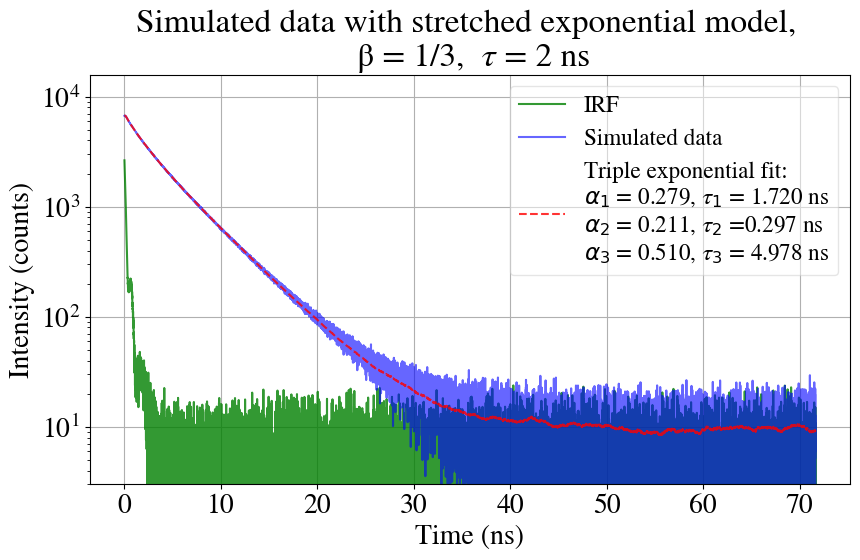

In [64]:
print(np.max(simulated_data))

import os
print(os.getcwd())

plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 20



IRF_noisy_max = IRF_noisy[np.argmax(simulated_data)-10:]
simulated_data_max = simulated_data[np.argmax(simulated_data)-10:]
t_truncated = t[np.argmax(simulated_data)-10:] - t[np.argmax(simulated_data)-10] 
Single_exponential_fit_max = Single_exponential_fit[np.argmax(simulated_data)-10:]
Double_exponential_fit_max = Double_exponential_fit[np.argmax(simulated_data)-10:]
Triple_exponential_fit_max = Triple_exponential_fit[np.argmax(simulated_data)-10:]
# Adjust the figure size for better layout
plt.figure(figsize=(9, 6))  # Increase width for better layout

# Plot data
plt.semilogy(t_truncated, IRF_noisy_max, 'g', label='IRF', alpha=0.8)
plt.semilogy(t_truncated, simulated_data_max, 'b', label='Simulated data', alpha=0.6)
plt.semilogy(t_truncated, Triple_exponential_fit_max, 'r', linestyle='--', alpha=0.8,
             label='Triple exponential fit:\n$α_{1}$ = 0.279, $𝜏_{1}$ = 1.720 ns\n$α_{2}$ = 0.211, $𝜏_{2}$ =0.297 ns \n$α_{3}$ = 0.510, $𝜏_{3}$ = 4.978 ns')
# Labeling
plt.xlabel('Time (ns)')
plt.ylabel('Intensity (counts)')
plt.title('Simulated data with stretched exponential model, \n β = 1/3,  𝜏 = 2 ns')

# Legend with adjusted position if necessary
plt.legend(loc='upper right', fontsize='small', framealpha=0.5)

# Grid and limits
plt.grid(True)
plt.ylim(bottom=3)

# Use tight layout
plt.tight_layout()

# Save and show plot
plt.savefig('stretched.png', dpi=600)
plt.show()

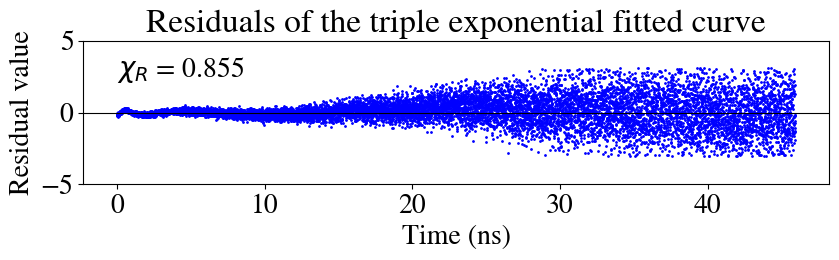

In [68]:


# Adjust the figure size for better layout
plt.figure(figsize=(9, 3))  # Increase height for better layout

# Plot data
plt.scatter(shifted_t_triple, filtered_residuals_triple, color ='blue', label = 'Double', s= 1)
plt.xlabel('Time (ns)')
plt.ylabel('Residual value')
plt.title('Residuals of the triple exponential fitted curve')
plt.axhline(0, color='black', lw=0.8)
plt.text(x=min(shifted_t_single), y=4, s='$\chi_{R}$ = 0.855', horizontalalignment='left', verticalalignment='top')
plt.ylim(-5, 5)

# Use tight layout
plt.tight_layout()

# Save and show plot
plt.savefig('triple_residual_new.png', dpi=600)
plt.show()
